In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import json
import os
from pathlib import Path
from pprint import pprint
import requests
import sys
from typing import Optional

if '..' not in sys.path: sys.path.append('..')

from datasets import load_dataset
from datasets.arrow_dataset import Dataset
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pydantic_yaml import parse_yaml_file_as
import torch
from torch import nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer, AddedToken, PreTrainedTokenizer, AutoTokenizer


from mllm.utils.utils import read_tsv, write_tsv



# QnA datasets exploration
## Config and paths

In [3]:
DATA_PATH = Path(os.path.expandvars('$HOME')) / 'data'
HOTPOTQA_URL = 'http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_train_v1.1.json'
HOTPOTQA_DATA_PATH = DATA_PATH / 'hotpotqa'

HOTPOTQA_DATA_PATH.mkdir(exist_ok=True)

## Hotpot QA
### Load

In [4]:

def get_hotpotqa(url: str, dir_path: Path) -> pd.DataFrame:
    fname = url.split('/')[-1]
    fpath = dir_path / fname
    fpath = fpath.with_suffix('.tsv')
    if fpath.exists():
        print(f'Load {fpath}')
        df = read_tsv(fpath)
    else:
        print(f'Load {url}')
        resp = requests.get(url)
        data = resp.json()
        df = pd.DataFrame.from_records(data)
        print(f'Write {fpath}')
        write_tsv(df, fpath)
    return df


In [5]:
df_hpqa = get_hotpotqa(HOTPOTQA_URL, HOTPOTQA_DATA_PATH)
df_hpqa

Load /home/misha/data/hotpotqa/hotpot_train_v1.1.tsv


,supporting_facts,level,question,context,answer,_id,type
0,"[[""Arthur's Magazine"", 0], ['First for Women',...",medium,Which magazine was started first Arthur's Maga...,"[['Radio City (Indian radio station)', [""Radio...",Arthur's Magazine,5a7a06935542990198eaf050,comparison
1,"[['Oberoi family', 0], ['The Oberoi Group', 0]]",medium,The Oberoi family is part of a hotel company t...,"[['Ritz-Carlton Jakarta', ['The Ritz-Carlton J...",Delhi,5a879ab05542996e4f30887e,bridge
2,"[['Allie Goertz', 0], ['Allie Goertz', 1], ['A...",hard,Musician and satirist Allie Goertz wrote a son...,"[['Lisa Simpson', ['Lisa Marie Simpson is a fi...",President Richard Nixon,5a8d7341554299441c6b9fe5,bridge
3,"[['Peggy Seeger', 0], ['Peggy Seeger', 1], ['E...",medium,What nationality was James Henry Miller's wife?,"[['Moloch: or, This Gentile World', ['Moloch: ...",American,5a82171f5542990a1d231f4a,bridge
4,"[['Cadmium chloride', 1], ['Ethanol', 0]]",medium,Cadmium Chloride is slightly soluble in this c...,"[['Cadmium chloride', ['Cadmium chloride is a ...",alcohol,5a84dd955542997b5ce3ff79,bridge
...,...,...,...,...,...,...,...
90442,"[['Kerry Remsen', 1], ['Bert Remsen', 0]]",medium,Kerry Remsen is the daughter of an actor with ...,"[['Kerry Remsen', ['Kerry Remsen is an America...",American,5a8f8db25542997ba9cb32b9,bridge
90443,"[['Northshore Mall', 0], ['Northshore Mall', 4...",easy,"Who manages both Northshore Mall in Peabody, M...","[['Green Tree Mall', ['Green Tree Mall is a sh...",Simon Property Group,5ae4f3615542993aec5ec0fd,bridge
90444,"[['Charlee Johnson', 4], ['DreamWorks', 0]]",medium,Charlee Johnson was part of a band that signed...,"[['Simon M. Woods', ['Simon M. Woods is a Brit...",Amblin Partners,5a903fc95542990a984935bd,bridge
90445,"[['Salt to the Sea', 1], ['MV Wilhelm Gustloff...",medium,What is the ship that sank in the Baltic sea a...,[['The I.V. Stalin White Sea – Baltic Sea Cana...,"MV ""Wilhelm Gustloff",5ab56e71554299494045efc8,bridge


### Statistics

In [8]:
level_vc = df_hpqa.level.value_counts()
level_vc

level
medium    56814
easy      17972
hard      15661
Name: count, dtype: int64

<Axes: xlabel='level'>

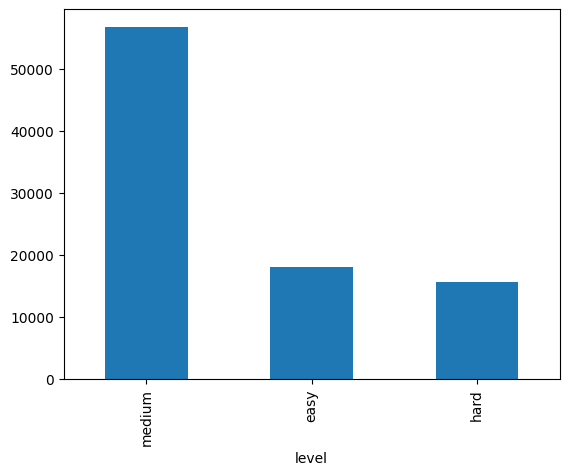

In [9]:
level_vc.plot.bar()

In [11]:
type_vc = df_hpqa.type.value_counts()
type_vc

type
bridge        72991
comparison    17456
Name: count, dtype: int64

<Axes: xlabel='type'>

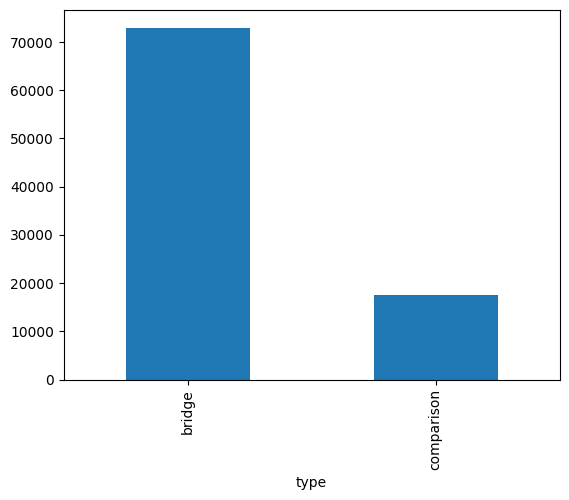

In [33]:
type_vc.plot.bar()

<Axes: xlabel='type,level'>

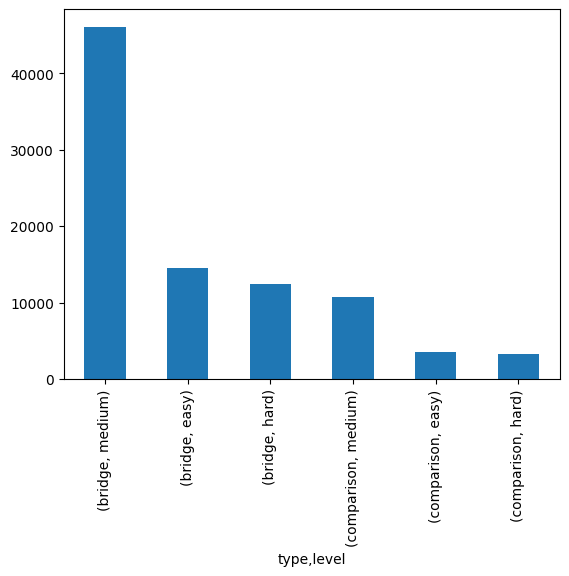

In [34]:
df_hpqa[['type', 'level']].value_counts().plot.bar()

### Comparison Questions

In [14]:
sample_question = df_hpqa[df_hpqa.type == 'comparison'].sample()
sample_question

,supporting_facts,level,question,context,answer,_id,type
37191,"[['Suor Angelica', 0], ['Louise (opera)', 0]]",medium,what do Suor Angelica and Louise have in common?,"[['Louise (opera)', ['Louise is an opera (""rom...",opera,5a8d2bac554299653c1aa13a,comparison


In [16]:
qrow = sample_question.iloc[0]
qrow.question

'what do Suor Angelica and Louise have in common?'

In [ ]:
supp_facts = eval(qrow.supporting_facts)
supp_facts

[['Suor Angelica', 0], ['Louise (opera)', 0]]

In [26]:
context = eval(qrow.context)
context

[['Louise (opera)',
  ['Louise is an opera ("roman musical" ) in four acts by Gustave Charpentier to an original French libretto by the composer, with some contributions by Saint-Pol-Roux, a symbolist poet and inspiration of the surrealists.']],
 ['Il trittico',
  ['Il trittico ("The Triptych") is the title of a collection of three one-act operas, "Il tabarro", "Suor Angelica", and "Gianni Schicchi", by Giacomo Puccini.',
   ' The work received its world premiere at the Metropolitan Opera on 14 December 1918.']],
 ['Jane Henschel',
  ['Jane Henschel (born 2 March 1952) is an American operatic mezzo soprano.',
   ' Henschel, who was born in Wisconsin, studied at the University of Southern California, and then pursued further studies in Germany, where she has made her home.',
   ' Her numerous opera appearances include Baba the Turk in Igor Stravinsky\'s "The Rake’s Progress" with Glyndebourne Festival Opera, the Saito Kinen Festival Matsumoto, and the Salzburg festival; Brangäne in Rich

### Bridge Questions

In [29]:
sample_question = df_hpqa[(df_hpqa.type == 'bridge') & (df_hpqa.level == 'easy')].sample()
sample_question

,supporting_facts,level,question,context,answer,_id,type
24328,"[['No. 22 Squadron RAF', 0], ['No. 22 Squadron...",easy,"During the Second World War, the No. 22 Squadr...","[['Fairey Swordfish', ['The Fairey Swordfish w...",The North Sea,5ae772d85542997ec272765d,bridge


In [32]:
qrow.question

'During the Second World War, the No. 22 Squadron of the Royal Air Force operated in the torpedo bomber role over this body of water located between Great Britain, Scandinavia, Germany, the Netherlands, Belgium, and France?'

In [30]:
qrow = sample_question.iloc[0]
qrow['supporting_facts']

"[['No. 22 Squadron RAF', 0], ['No. 22 Squadron RAF', 3], ['North Sea', 0]]"

In [31]:
eval(qrow.context)

[['Fairey Swordfish',
  ['The Fairey Swordfish was a biplane torpedo bomber designed by the Fairey Aviation Company.',
   ' Originating in the early 1930s, the Swordfish, nicknamed "Stringbag", was operated by the Fleet Air Arm of the Royal Navy, in addition to having been equipped by the Royal Air Force (RAF) alongside multiple overseas operators, including the Royal Canadian Air Force (RCAF) and the Royal Netherlands Navy.',
   ' It was initially operated primarily as a fleet attack aircraft; during its later years, the Swordfish became increasingly used as an anti-submarine and training platform.',
   ' The type was in frontline service throughout the Second World War, but it was already considered obsolescent at the outbreak of the conflict in 1939.']],
 ['No. 76 Squadron RAF',
  ['No. 76 Squadron was a squadron of the Royal Air Force.',
   ' It was formed during World War I as a home defence fighter squadron and in its second incarnation during World War II flew as a bomber squadr